# Time series forecasting with DeepAR - Wikimedia pageview data

- This notebook we train a deepAR model using 2Years/ over a smaller subset (17 projects) of wiki-projects pageview data within requested time range, and test the model with both wiki and synthetic data.  
- Model pipeline: Request to Wiki REST api >> save_jason() to S3 bucket >> train model >> deploy trained model on Sagemaker, create endpoint >> request inference >> get prediction >> evaluation with test metric 

In [ ]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
#from preprocessor import save_json

In [2]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.5.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [3]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [4]:
bucket = 'sagemaker-deepar20190120'
prefix = 'sagemaker/wiki-test-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Predict setting

We predict the next 48 points of time series.
The time series that we use have hourly granularity.

In [6]:
freq = 'H'
prediction_length = 48

`context_length`: how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`.

In [7]:
context_length = 72

Useful functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3. (didn't call during this example)

In [8]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

### Get wikimedia pageview data from its REST API
We request the http requests sent by users to wiki projects. The output will be a json file with required format, each line contains hourly pageview numbers from `start` to `end`. Output files are saved in a S3 bucket.
- (A side note: wiki api allows 200 requests/s maximum, don't get blacklisted.)
- (Anote side note: the response will be json objects, each has a time stamp and corresponding time series values such as pageview, the maximum number of returned objects is 5000 that's why I use time delta = 200 days = 4800 objects for each request)

In [9]:
import datetime
import requests
import json
import time

all_data = []
project_list = []
delta = datetime.timedelta(days=199)
hour = datetime.timedelta(hours=1)
zero = datetime.timedelta(hours=0)


def save_json(start, end, out_path, input_path):
    s3filesystem = s3fs.S3FileSystem()
    start_date = datetime.datetime.strptime(start, '%Y%m%d')
    end_date = datetime.datetime.strptime(end, '%Y%m%d')
    if (end_date - start_date).days < 0:
        raise Exception('start date should NOT after end date')

    expected_size = ((end_date - start_date).days + 1) * 24

    # provide wiki-project list here!
    with open(input_path) as f:
        projects = f.read().splitlines()

    for item in projects:
        data = get_single_views(item, start_date, end_date)
        if len(data['target']) == expected_size:
            all_data.append(data)
            project_list.append(item)

    # convert all items to JSON and write to a file
    print('saving data')
    print(project_list)
    with open('project_list.txt', 'w') as f:
        for item in project_list:
            f.write("%s\n" % item)
    with s3filesystem.open(out_path, 'w') as outfile:
        outfile.write('\n'.join(json.dumps(i) for i in all_data) + '\n')
    all_data.clear()
    project_list.clear()


def get_single_views(item, start_date, end_date):
    base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/' \
               + item \
               + '/all-access/user/hourly/'
    # dict is used to save JSON of each domain
    data = dict()
    data['start'] = start_date.strftime('%Y-%m-%d') + ' 00:00:00'
    data['target'] = []

    while start_date <= end_date:
        if start_date + delta <= end_date:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + (start_date + delta).strftime('%Y%m%d') + '23'
            end_check = start_date + delta + 23 * hour
        else:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + end_date.strftime('%Y%m%d') + '23'
            end_check = end_date + 23 * hour
        # make a API request here!!!
        response = requests.get(final_url)
        time.sleep(0.05)
        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print("<-----Error---->: " + final_url + str(e))
            break
        print('<-----OK----->' + final_url)  # debug
        output = response.json()
        print('processed data points: ' + str(len(output['items'])))  # debug
        temp = start_date - hour
        for i in output['items']:
            curr = datetime.datetime.strptime(i['timestamp'], '%Y%m%d%H')
            while curr - temp > hour:
                data['target'].append(0)
                temp += hour
            data['target'].append(i['views'])
            temp = curr

        while (end_check - temp) > zero:
            data['target'].append(0)
            temp += hour

        start_date += datetime.timedelta(days=200)

    return data

In [10]:
train_start = '20160101'
train_end = '20180101'
save_json(train_start,train_end,s3_data_path + "/train_subset/train.json", 'wp.txt')
test_start = '20180101'
test_end = '20190101'
save_json(test_start,test_end,s3_data_path + "/test_subset/test.json", 'wp.txt')

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikiversity.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikiversity.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikiversity.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/incubator.wikimedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/wikimediafoundation.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/wikimediafoundation.org/all-access/user/hourly/2018072000/2019010123
processed data points: 389
saving data
['en.wikipedia.org', 'de.wikipedia.org', 'ja.wikipedia.org', 'zh.wikipedia.org', 'ru.wikipedia.org', 'commons.wikimedia.org', 'species.wikimedia.org', 'outreach.wikimedia.org', 'en.wiktionary.org', 'wikidata.org', 'en.wikinews.org', 'en.wikivoyage.org', 'wikisource.org', 'en.wikiversity.org', 'en.wikibooks.org', 'incubator.wikimedia.org', 'wikimediafoundation.org']


### Train a model

In [11]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

In [12]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [13]:
estimator.set_hyperparameters(**hyperparameters)

In [14]:
data_channels = {
    "train": "s3://{}/train_subset/".format(s3_data_path),
    "test": "s3://{}/test_subset/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-01-24-17-08-52-332


2019-01-24 17:08:52 Starting - Starting the training job...
2019-01-24 17:08:53 Starting - Launching requested ML instances...
2019-01-24 17:09:50 Starting - Preparing the instances for training.........
2019-01-24 17:11:02 Downloading - Downloading input data..
Arguments: train
[01/24/2019 17:11:29 INFO 139699856623424] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[01/24/2019 17:11:29 INFO 139699856623424] Reading provided configuration from /opt/ml/input/

[01/24/2019 17:11:52 INFO 139699856623424] Epoch[7] Batch[5] avg_epoch_loss=10.495376
[01/24/2019 17:11:52 INFO 139699856623424] Epoch[7] Batch [5]#011Speed: 189.29 samples/sec#011loss=10.495376
[01/24/2019 17:11:53 INFO 139699856623424] processed a total of 317 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2280.557870864868, "sum": 2280.557870864868, "min": 2280.557870864868}}, "EndTime": 1548349913.129896, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548349910.849275}

[01/24/2019 17:11:53 INFO 139699856623424] #throughput_metric: host=algo-1, train throughput=138.993811425 records/second
[01/24/2019 17:11:53 INFO 139699856623424] #progress_metric: host=algo-1, completed 40 % of epochs
[01/24/2019 17:11:53 INFO 139699856623424] loss did not improve
[01/24/2019 17:11:53 INFO 139699856623424] Epoch[8] Batch[0] avg_epoch_loss=11.380995
[01/24/2019 17:11:54 INFO 139699856623424] Epoch[8] Batch[5] avg_epoch_loss=11

[01/24/2019 17:12:12 INFO 139699856623424] Epoch[16] Batch[0] avg_epoch_loss=10.603392
[01/24/2019 17:12:13 INFO 139699856623424] Epoch[16] Batch[5] avg_epoch_loss=10.268228
[01/24/2019 17:12:13 INFO 139699856623424] Epoch[16] Batch [5]#011Speed: 171.40 samples/sec#011loss=10.268228
[01/24/2019 17:12:14 INFO 139699856623424] processed a total of 303 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2319.040060043335, "sum": 2319.040060043335, "min": 2319.040060043335}}, "EndTime": 1548349934.278796, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548349931.959436}

[01/24/2019 17:12:14 INFO 139699856623424] #throughput_metric: host=algo-1, train throughput=130.651035787 records/second
[01/24/2019 17:12:14 INFO 139699856623424] #progress_metric: host=algo-1, completed 85 % of epochs
[01/24/2019 17:12:14 INFO 139699856623424] best epoch loss so far
[01/24/2019 17:12:14 INFO 139699856623424] Saved checkpoint to "/opt/ml/m


2019-01-24 17:12:39 Uploading - Uploading generated training model
2019-01-24 17:12:39 Completed - Training job completed
Billable seconds: 98


### Create endpoint and predictor

In [15]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-01-24-17-08-52-332
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-01-24-17-08-52-332
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-01-24-17-08-52-332


--------------------------------------------------------------------------------------!

In [16]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [17]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions, plot and evaluate the results

### Make prediction for `wiki` data

In [ ]:
data_location = "s3://{}/wiki/test_wiki.json".format(s3_data_path)
df_ts = pd.read_json(data_location, lines = True)
df_ts.head()

In [19]:
num_pt = len(df_ts.iloc[1,1])
num_ts = len(df_ts)-1

time_series_wiki = [] 
for k in range(num_ts):
    t0 = df_ts.iloc[k,0]
    data = df_ts.iloc[k,1]
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
    time_series_wiki.append(pd.Series(data=data, index=index))

In [20]:
time_series_wiki_predict = []
for ts in time_series_wiki:
    time_series_wiki_predict.append(ts[:-prediction_length])

In [21]:
list_of_wiki_pred = predictor.predict(time_series_wiki_predict[:5])
actual_wiki = time_series_wiki[:5]

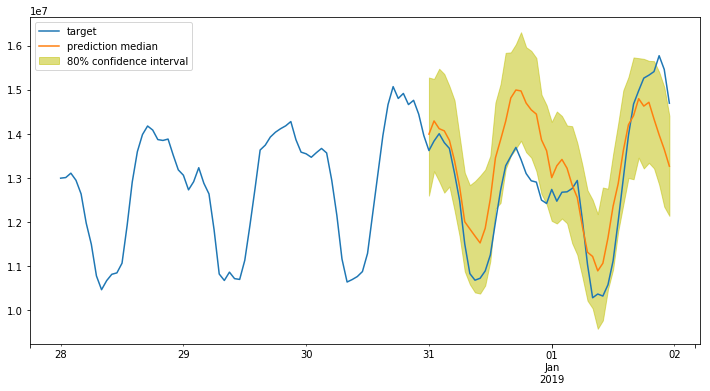

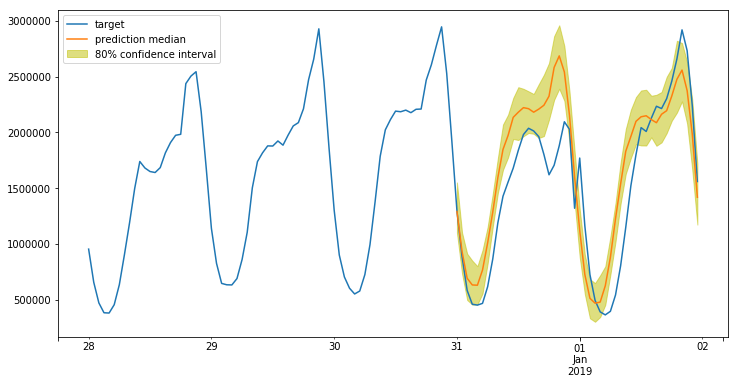

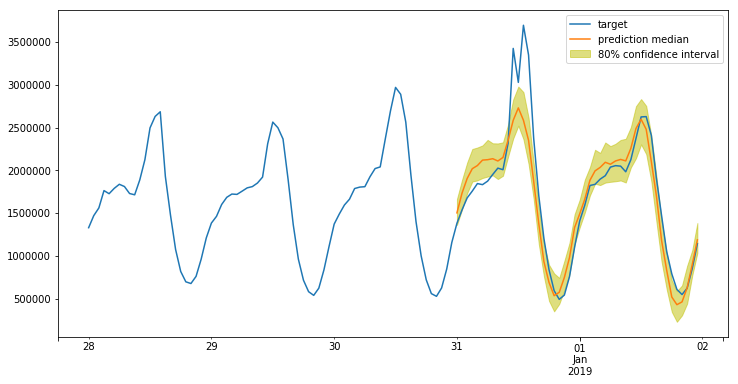

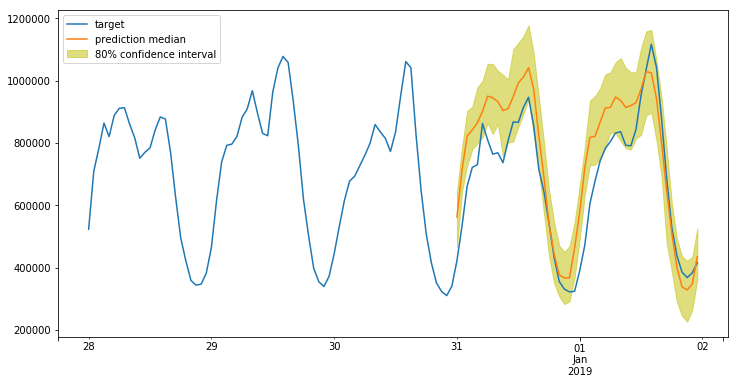

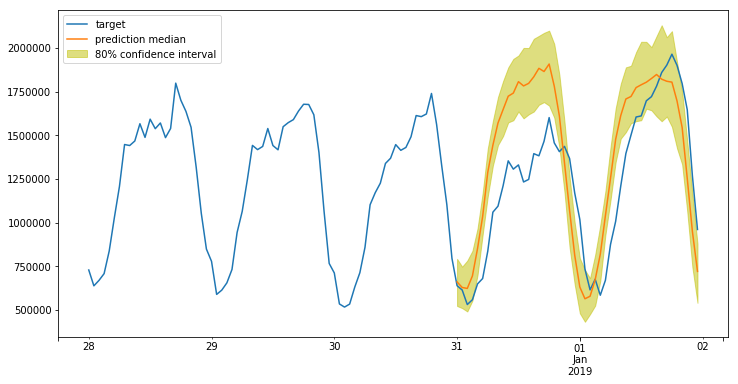

In [22]:
for k in range(len(list_of_wiki_pred)):
    plt.figure(figsize=(12,6))
    actual_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k]['0.1']
    p90 = list_of_wiki_pred[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### Make prediction for `synthetic` data: sin() with noise.

Data contain 200 noisy time series, each consisting of 400 data points and with seasonality of 24 hours. 
All time series start at the same time point `t0`.

In [23]:
t0 = '2016-01-01 00:00:00'
data_length = 400
num_ts = 200
period = 24

In [24]:
time_series_synthetic = []
for k in range(num_ts):
    level = 10000 * np.random.rand()
    seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
    sig = 0.05 * level # noise parameter (constant in time)
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
    noise = sig*np.random.randn(data_length)
    data = source + noise
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
    time_series_synthetic.append(pd.Series(data=data, index=index))

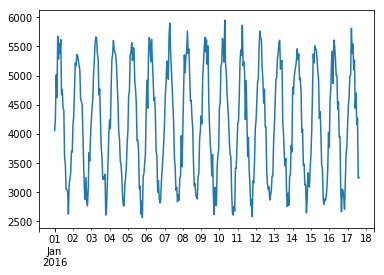

In [25]:
time_series_synthetic[0].plot()
plt.show()

In [26]:
time_series_to_predict = []
for ts in time_series_synthetic:
    time_series_to_predict.append(ts[:-prediction_length])

In [27]:
list_of_df = predictor.predict(time_series_to_predict[:5])
actual_data = time_series_synthetic[:5]

In [28]:
len(list_of_df[0]['0.5'].values)

48

In [29]:
len(actual_data[0][-prediction_length:].values)

48

### moving average as a baseline model

- not able to handle seasonality

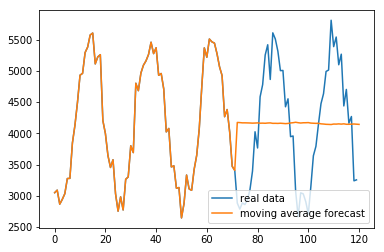

In [30]:
db = actual_data[0][-prediction_length-context_length:].values
forecast = np.zeros(len(db) + 1)
optimal_n = context_length
for i in range(0, optimal_n):
    forecast[i] = db[i]
for i in range(0, len(db) - optimal_n + 1):
        forecast[i+optimal_n] = np.mean(db[i:i+optimal_n])
plt.plot(db,label = 'real data')
plt.plot(forecast, label = 'moving average forecast')
plt.legend()
plt.show()


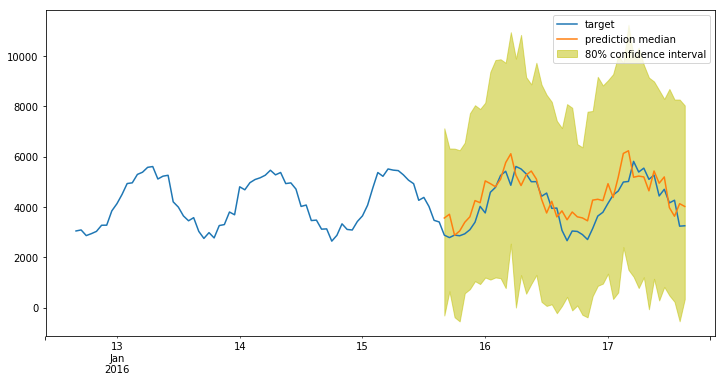

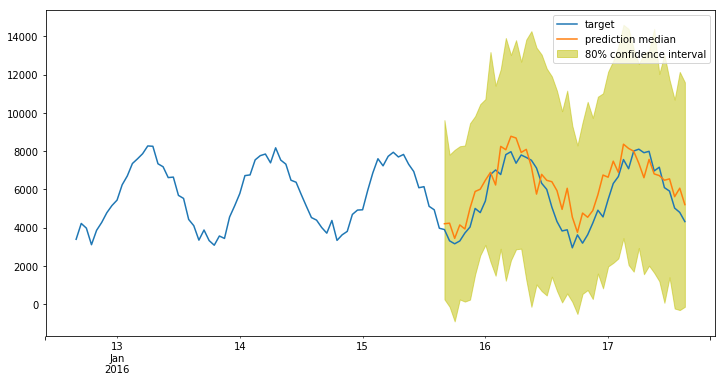

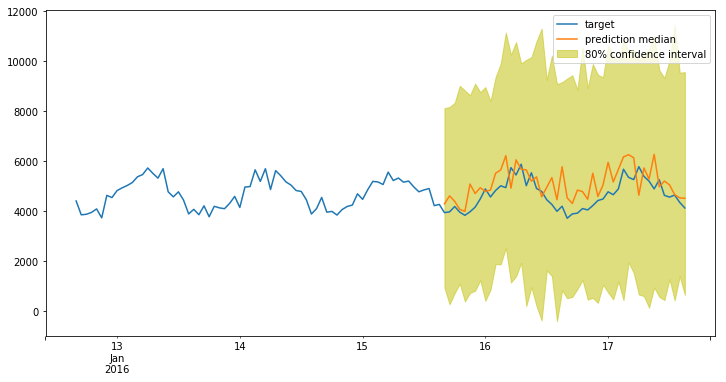

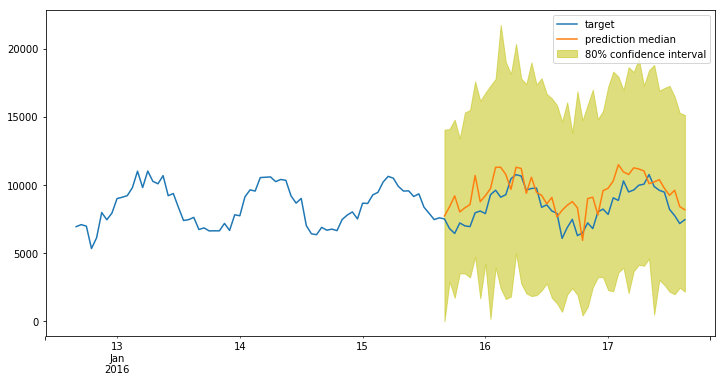

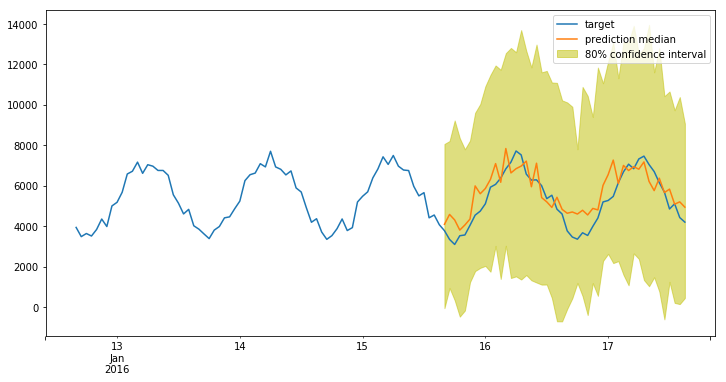

In [31]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    #plt.plot(forecast, label = 'moving average forecast')
    plt.legend()
    plt.show()

### Metrics to evaluate the prediction
- Mean absolute percentage error
- Mean absolute error with log1p
- Symmetric mean absolute percentage error
- Symmetric mean absolute percentage error differentiable
- others?

In [32]:
# Approximated differentiable SMAPE
def differentiable_smape(true, predicted):
    epsilon = 0.1
    true_o = true
    pred_o = predicted
    summ = np.maximum(np.abs(true_o) + np.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = np.abs(pred_o - true_o) / summ
    return smape

# SMAPE, rounded up to the closest integer
def rounded_smape(true, predicted):
    true_o = np.int(np.round(true))
    pred_o = np.round(predicted).astype(np.int32)
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# SMAPE stardard definition
def smape(true, predicted):
    true_o = true
    pred_o = predicted
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# MAE standard definition
def mape(true, predicted):
    true_o = true
    pred_o = predicted
    denom = np.abs(true_o)
    mape = np.where(denom==0, 0, np.abs(pred_o - true_o) / denom)
    return mape


# MAE on log1p
def mape1p(true, predicted):
    epsilon = 0.1
    true_o = np.log1p(true + epsilon)
    pred_o = np.log1p(predicted + epsilon)
    error = np.abs(true_o - pred_o)/np.abs(true_o)
    return error

In [33]:
# input pd.series in which index = time stamps, value = time series values
# actual_series and pred_series should have exactly matched timestamps

def plot_metrics(actual_series, pred_series):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    metric_smape = differentiable_smape(actual_series.values, pred_series.values)
    metric_mape = mape(actual_series.values, pred_series.values)
    metric_maelog1p = mape1p(actual_series.values, pred_series.values)
    metric_smape_orig = smape(actual_series.values, pred_series.values)
    plt.figure(figsize=(12,6))
    plt.plot(pred_series.index, metric_smape_orig, label = 'smape standard = {}'.format(metric_smape_orig.mean()))  
    plt.plot(pred_series.index, metric_smape, label = 'smape differentialble = {}'.format(metric_smape.mean()))
    plt.plot(pred_series.index, metric_mape, label = 'mape standard = {}'.format(metric_mape.mean()))
    plt.plot(pred_series.index, metric_maelog1p, label = 'mape with log(1 + eplison +val) = {}'.format(metric_maelog1p.mean()))
    plt.xlabel('Time stamp of prediction')
    plt.ylabel('Prediction metric')
    plt.legend()
    plt.show()

### Plot the metrics for wiki data prediction

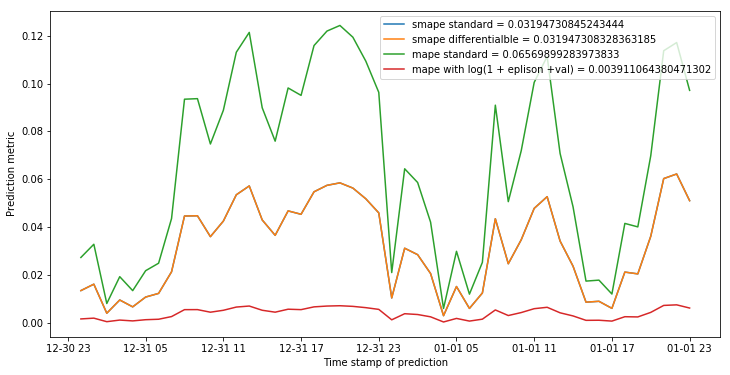

In [34]:
plot_metrics(actual_wiki[0][-prediction_length:], list_of_wiki_pred[0]['0.5'])

### Plot the metrics for synthetic data prediction

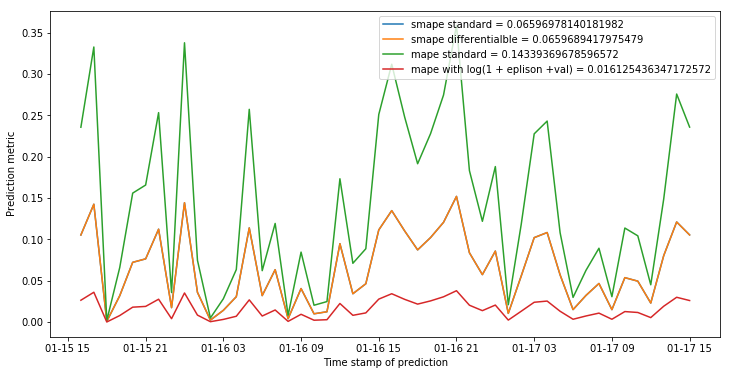

In [35]:
plot_metrics(actual_data[0][-prediction_length:], list_of_df[0]['0.5'])

### Delete endpoint

In [36]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2019-01-24-17-08-52-332
